In [1]:
# """

# This notebook is a template for computing the common lines matrix. Examples are
# 1) Synthetic data using images genereated from Aspire
# 2) Real data from Verbeke et al 2019, JSB

# TODO
# - add code to compute the A matrix from the gt rotations for synthetic data
# - add function to check that theta_ij is correctly estimated

# TODO EV:
# - resolution of inputs
#     - do I need to lpf before fourier crop? rescaling?

# """

In [2]:
import os
import time
import pickle
import logging

import cl_utils as cl

import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from aspire.image import Image
from aspire.noise import WhiteNoiseAdder
from aspire.operators import ScalarFilter
from aspire.source.simulation import Simulation
from aspire.source import ArrayImageSource
from aspire.utils import Rotation, gaussian_2d
from aspire.volume import Volume

/home/ev9102/.conda/envs/aspire/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
###############################

# Example with synthetic data #

###############################

In [4]:
### Inputs ###

DATA_DIR = '/scratch/network/ev9102/Data/'  # set the input directory with your EMDBs 
emd_ids = ['emd_4214.map', 'emd_2811.map', 'emd_2858.map', 'emd_22052.map']  # 40S, 60S, 80S, Apo
n_img = [5, 5, 5, 5]  # number of images for each structure
L = 64  # size to downsample the volume
snr = 10  # snr for additive wgn to projection images
add_mask = True  # add circular mask to images
mask_radius = L//2  # in pixels
use_noisy = False  # option to use the noisy images of clean images
angles = np.arange(0, 360, 1)  # angular sampling for line projections
r = np.array([cl.get_random_euler_angles(n) for n in n_img])  # pick Euler angles (in rads) for 'ZYZ' convention

In [5]:
### load volumes ###

logger = logging.getLogger(__name__)

volumes = {}

for i, entry in enumerate(emd_ids):
    with mrcfile.open(os.path.join(DATA_DIR, entry)) as mrc:
        vol = mrc.data
        vox = mrc.voxel_size.x
        mrc.close()
        volumes[i] = (vol, vox)
    
### now downsample to the nearest integer voxel size <- this needs checking
voxel_sizes = [volumes[k][1] for k, v in volumes.items()]
# new_voxel_size = int(np.ceil(np.amax(voxel_sizes)))  # or can be set manually
new_voxel_size = 4
rescale_factors = [new_voxel_size / vox for vox in voxel_sizes]
volumes = {
    k: cl.fourier_downsample(v[0], rescale_factors[idx], rescale=True) 
    for k, (idx, v) in enumerate(volumes.items())
}  
new_vol_shapes = np.array([v.shape[0] for k, v in volumes.items()])
assert L <= np.amin(new_vol_shapes), "downsample size must be less than current resolution"
    
### instantiate an Aspire "Volume", which is downsampled to LxLxL
t0 = time.time()
volumes = {k: Volume(v).downsample(L) for k, v in volumes.items()}
print('load volumes: ', time.time() - t0)

load volumes:  13.962508201599121


In [6]:
### create Aspire simulation source to generate synthetic images ###

assert len(emd_ids) == len(n_img), "number of volumes and image stack sizes must be equal length"

rots = [Rotation.from_euler(ri) for ri in r]  # list of rotations in Aspire format
shifts = [np.zeros((n, 2)) for n in n_img]  # not including shifts for now
amplitudes = [np.ones(n) for n in n_img]

src = {
    k: Simulation(vols=v,  # our Volume
                  L=v.resolution,  # resolution, should match Volume
                  n=n_img[idx],  # number of projection images
                  angles=rots[idx].angles,  # pass our rotations as Euler angles
                  offsets=shifts[idx],  # translations (wrt to origin)
                  amplitudes=amplitudes[idx],  # amplification ( 1 is identity)
                  noise_adder=WhiteNoiseAdder.from_snr(snr=snr),
                  seed=12345,  # RNG seed for reproducibility
                  dtype=v.dtype  # match our datatype to the Volume.
                 )
    for k, (idx, v) in enumerate(volumes.items())
}

### make the final image stack, simplify this later

clean_images = {k: s.projections[:n_img[idx]].asnumpy().copy() for k, (idx, s) in enumerate(src.items())}

noisy_images = {k: s.images[:n_img[idx]].asnumpy().copy() for k, (idx, s) in enumerate(src.items())}

if add_mask:
    rdists = cl.radial_distance_grid([L, L])
    mask = cl.sphere_mask(rdists, mask_radius)
    for k, imgs in clean_images.items():
        for idx, img in enumerate(imgs):
            clean_images[k][idx] = mask * img 
    for k, imgs in noisy_images.items():
        for idx, img in enumerate(imgs):
            noisy_images[k][idx] = mask * img 

images = []

if use_noisy:
    for k, imgs in noisy_images.items():
        for img in imgs:
            images.append(img)
else:
    for k, imgs in clean_images.items():
        for img in imgs:
            images.append(img)
            
images = np.array(images)

2023-09-28 11:50:39,428 INFO [aspire.source.image] Creating Simulation with 5 images.
2023-09-28 11:50:39,434 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=None to generation pipeline


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

2023-09-28 11:50:39,532 INFO [aspire.source.image] Creating Simulation with 5 images.
2023-09-28 11:50:39,534 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=None to generation pipeline



100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

2023-09-28 11:50:39,606 INFO [aspire.source.image] Creating Simulation with 5 images.
2023-09-28 11:50:39,608 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=None to generation pipeline



100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

2023-09-28 11:50:39,679 INFO [aspire.source.image] Creating Simulation with 5 images.
2023-09-28 11:50:39,681 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=None to generation pipeline



100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


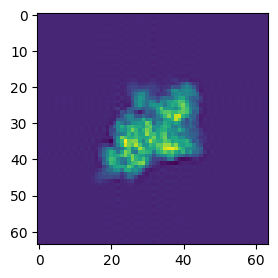

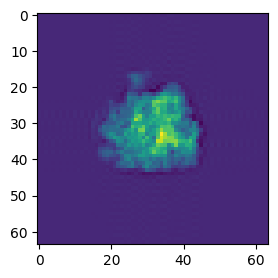

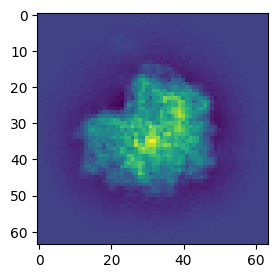

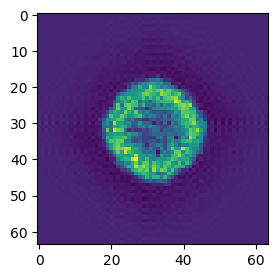

In [7]:
idx = [0, 5, 10, 15]

for i in idx:
    plt.figure(figsize=(3,3))
    plt.imshow(images[i])
    plt.show()

In [8]:
### compute the line projection distances and form common lines matrix
### format is (img1, img2) : (theta1, theta2) --> angles to rotate for common lines using np conventions

n_total = images.shape[0]

t0 = time.time()
cl_angles = cl.compute_common_line_angles(images, angles)
print('compute cl distances: ', time.time() - t0)

### now form A, the common lines matrix

A = cl.form_cl_matrix_from_cl_angles(cl_angles, n_total)

compute cl distances:  5.299465656280518


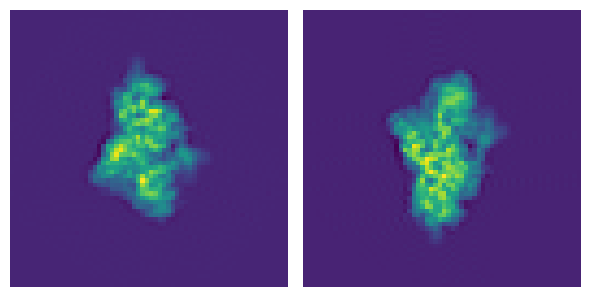

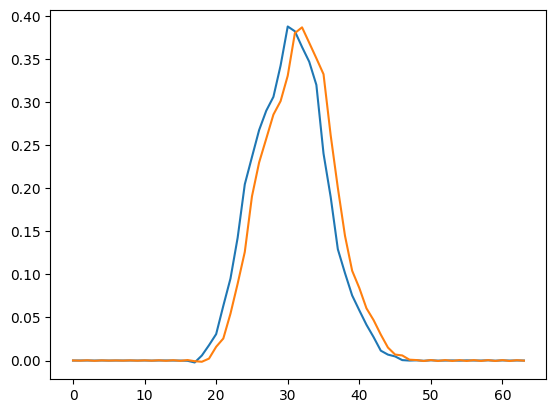

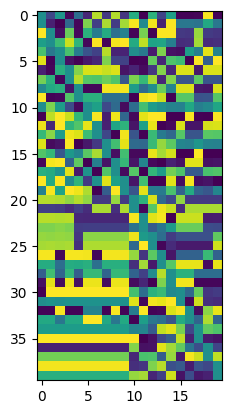

In [9]:
### plotting ###
idx1 = 0 
idx2 = 1

a1 = cl_angles[(idx1, idx2)][0]
a2 = cl_angles[(idx1, idx2)][1]
img1 = ndi.rotate(images[idx1], a1, reshape=False)
img2 = ndi.rotate(images[idx2], a2, reshape=False)
cl.two_plot(img1, img2, size=6)

plt.plot(img1.sum(axis=0))
plt.plot(img2.sum(axis=0))
plt.show()

plt.imshow(A)
plt.show()

In [10]:
### save matrix to matlab format
# from scipy.io import savemat
# cl_mat_dict = {'A': A}
# savemat('A.mat', cl_mat_dict)

In [11]:
###############################

#   Example with real data    #

###############################

In [12]:
### notes
### - the common lines distances in the original paper included region extraction and shifting of the line projections
### - add clustering here?
### - is it worth parallelizing or trying EMD?

In [13]:
mrcs = 'Data/mixture_2D.mrcs'

images = []

with mrcfile.open(mrcs) as mrc:
    for data in mrc.data:
        images.append(data)
    mrc.close()
    
images = np.array(images)

with open('Data/mixture_labels.pkl', 'rb') as f:
    labels = pickle.load(f)

with open('Data/mixture_clusters.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [14]:
n_total = images.shape[0]

t0 = time.time()
cl_angles = cl.compute_common_line_angles(images, angles)
print('compute cl distances: ', time.time() - t0)

### now form A, the common lines matrix

A = cl.form_cl_matrix_from_cl_angles(cl_angles, n_total)

compute cl distances:  200.55350041389465


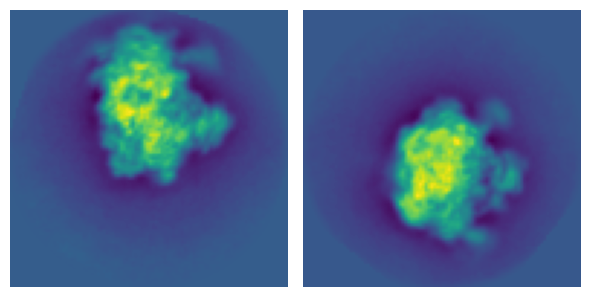

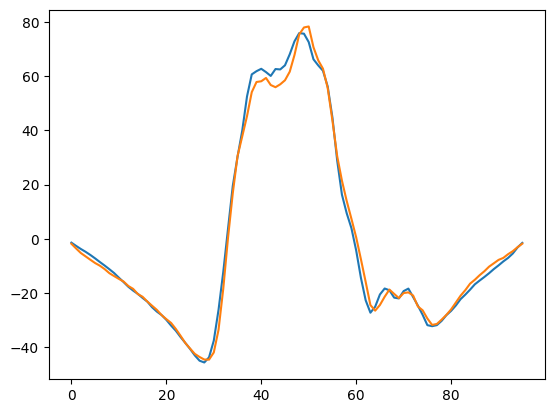

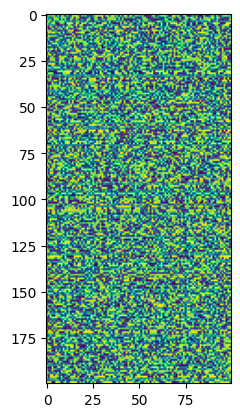

In [15]:
### plotting ###
idx1 = 84 
idx2 = 88


a1 = cl_angles[(idx1, idx2)][0]
a2 = cl_angles[(idx1, idx2)][1]
img1 = ndi.rotate(images[idx1], a1, reshape=False)
img2 = ndi.rotate(images[idx2], a2, reshape=False)
cl.two_plot(img1, img2, size=6)

plt.plot(img1.sum(axis=0))
plt.plot(img2.sum(axis=0))
plt.show()

plt.imshow(A)
plt.show()

In [16]:
### save matrix to matlab format
# from scipy.io import savemat
# cl_mat_dict = {'A': A}
# savemat('A.mat', cl_mat_dict)

In [17]:
clusters[1], labels['40S']

([12, 48, 53, 54, 60, 64, 70, 73, 75, 91, 92], [22, 64, 73, 75, 91, 92])